In [3]:
import sys
import os
import pandas as pd
from ema_workbench.analysis.parcoords import ParallelAxes, get_limits
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 5]
sys.path.append('..')
import numpy as np
import random
from scipy.stats import mannwhitneyu

from sklearn.preprocessing import MinMaxScaler #to rescale Euclidean mean
from itertools import chain
from platypus import Solution, Problem

import problem_formulation_original, problem_formulation_gini, problem_formulation_euclidean

### Make dictionary out of all solutions

In [4]:
pareto_sets = {}

ethical_formulations = ['TraditionalPrinciple',
                        'CombinedTraditionalGiniMean', 
                        'CombinedTraditionalGiniStd',
                        'CombinedTraditionalGiniRatioStdMean',
                        'CombinedTraditionalEuclideanMean',
                        'CombinedTraditionalEuclideanStd',
                        'CombinedTraditionalEuclideanRatioStdMean',
]

## call refsets if already saved

folder_destination_data = '/Users/farleyrimon/Documents/GitHub/MUSEH2O/susquehanna/refsets' 
folder_destination = '/Users/farleyrimon/Documents/GitHub/MUSEH2O/susquehanna/refsets' 

reference_sets = {}
for entry in ethical_formulations:
    reference_sets[entry] = pd.read_csv(os.path.join(f'{folder_destination_data}', f"{entry}_refset_with_variables.csv"))

    
## call other dictionaries from the prepocessing 

import pickle

# open a file, where you stored the pickled data
file_all_ineq = open(f'{folder_destination_data}/dict_principles_all_inequality_metrics.pkl', 'rb')
file_obj = open(f'{folder_destination_data}/dict_principles_objectives.pkl', 'rb')

# dump information to that file
dict_principles_all_inequality_metrics = pickle.load(file_all_ineq)
dict_principles_objectives = pickle.load(file_obj)


# close the file
file_all_ineq.close()
file_obj.close()


In [5]:
def column_renamer_reference_set(df):
    new_columns = ['Hydropower revenue', 'Atomic PP', 'Baltimore', 'Chester', 'Environment', 'Recreation', 'Equity']
    # Get the current column names
    current_columns = df.columns

    # Create a mapping dictionary to map old column names to new column names
    mapping = dict(zip(current_columns[-7:], new_columns))

    # Rename the columns using the mapping dictionary
    df = df.rename(columns=mapping)
    obj_columns = df.columns[-7:]
    df[obj_columns] = df[obj_columns].apply(pd.to_numeric, errors='coerce')
    return df


for i in range(7):
    reference_sets[ethical_formulations[i]] = column_renamer_reference_set(reference_sets[ethical_formulations[i]])
    
    

In [6]:
def column_renamer(df, ethical_formulation, formulation_number):
    df = df.copy()
    new_columns = ['Hydropower revenue', 'Atomic PP', 'Baltimore', 'Chester', 'Environment', 'Recreation', 'Gini Mean', 'Euclidean Mean', 'Gini Std', 'Euclidean Std', 'Gini Ratio', 'Euclidean Ratio', 'Formulation']
    df = df.drop('Equity', axis=1)
    df['principle'] = df['principle'].replace(ethical_formulation, formulation_number)
    df.columns = new_columns
    return df

j = 1
for i in range(7):
    dict_principles_all_inequality_metrics[ethical_formulations[i]] = column_renamer(dict_principles_all_inequality_metrics[ethical_formulations[i]],ethical_formulations[i],f'F{j}')
    j += 1


In [7]:
df_traditional_log = dict_principles_all_inequality_metrics[ethical_formulations[0]]
df_gini_std_log = dict_principles_all_inequality_metrics[ethical_formulations[2]]
df_gini_mean_log = dict_principles_all_inequality_metrics[ethical_formulations[1]]
df_eucli_std_log = dict_principles_all_inequality_metrics[ethical_formulations[5]]
df_gini_ratio_log = dict_principles_all_inequality_metrics[ethical_formulations[3]]
df_eucli_mean_log = dict_principles_all_inequality_metrics[ethical_formulations[4]]
df_eucli_ratio_log = dict_principles_all_inequality_metrics[ethical_formulations[6]]


# Statistical tests

## Kruskall Wallis Test

The Kruskal-Wallis H test (sometimes also called the "one-way ANOVA on ranks") is a rank-based nonparametric test that can be used to determine if there are statistically significant differences between two or more groups of an independent variable on a continuous variable. 


We will use the Kruskall Wallis test to determine if:

- The distribution of two formulations are by no chance random when compared to each other (Mann-Whitney U test)
- The distribution between objectives of the difference formulation are by no chance random when compared

We can reject the null hypothesis where the distribution of objectives and is dependent on the distribution of the distributive justice value. Their distribution is different such that the statistical significance of this hypothesis is true (p<0.05).

In [8]:
from scipy import stats
df_traditional = pd.DataFrame(reference_sets[ethical_formulations[0]].iloc[:,-7:])
df_traditional.name = 'F1'
df_gini_mean = pd.DataFrame(reference_sets[ethical_formulations[1]].iloc[:,-7:])
df_gini_mean.name = 'F2'
df_gini_std = pd.DataFrame(reference_sets[ethical_formulations[2]].iloc[:,-7:])
df_gini_std.name = 'F3'
df_gini_ratio = pd.DataFrame(reference_sets[ethical_formulations[3]].iloc[:,-7:])
df_gini_ratio.name = 'F4'
df_eucli_mean = pd.DataFrame(reference_sets[ethical_formulations[4]].iloc[:,-7:])
df_eucli_mean.name = 'F5'
df_eucli_std = pd.DataFrame(reference_sets[ethical_formulations[5]].iloc[:,-7:])
df_eucli_std.name = 'F6'
df_eucli_ratio = pd.DataFrame(reference_sets[ethical_formulations[6]].iloc[:,-7:])
df_eucli_ratio.name = 'F7'

list_df = [df_gini_mean,df_gini_std,df_gini_ratio,df_eucli_mean, df_eucli_std,df_eucli_ratio]

for df in list_df:
    print(f"\nFormulation: {df.name}")
    p_values_col = []

    for col in df.columns:
        y = df[col]
        x = df['Equity']
        h, p_value = stats.kruskal(x, y)
        print(f"Column {col}: H-statistic={h:.2f}, p-value={p_value:.4f}")
        


Formulation: F2
Column Hydropower revenue: H-statistic=519.75, p-value=0.0000
Column Atomic PP: H-statistic=485.11, p-value=0.0000
Column Baltimore: H-statistic=350.84, p-value=0.0000
Column Chester: H-statistic=515.32, p-value=0.0000
Column Environment: H-statistic=517.51, p-value=0.0000
Column Recreation: H-statistic=567.53, p-value=0.0000
Column Equity: H-statistic=0.00, p-value=1.0000

Formulation: F3
Column Hydropower revenue: H-statistic=383.25, p-value=0.0000
Column Atomic PP: H-statistic=383.25, p-value=0.0000
Column Baltimore: H-statistic=383.25, p-value=0.0000
Column Chester: H-statistic=383.25, p-value=0.0000
Column Environment: H-statistic=383.25, p-value=0.0000
Column Recreation: H-statistic=423.73, p-value=0.0000
Column Equity: H-statistic=0.00, p-value=1.0000

Formulation: F4
Column Hydropower revenue: H-statistic=567.75, p-value=0.0000
Column Atomic PP: H-statistic=563.14, p-value=0.0000
Column Baltimore: H-statistic=555.75, p-value=0.0000
Column Chester: H-statistic=5


Formulation: F2

Formulation: F3

Formulation: F4

Formulation: F5

Formulation: F6

Formulation: F7


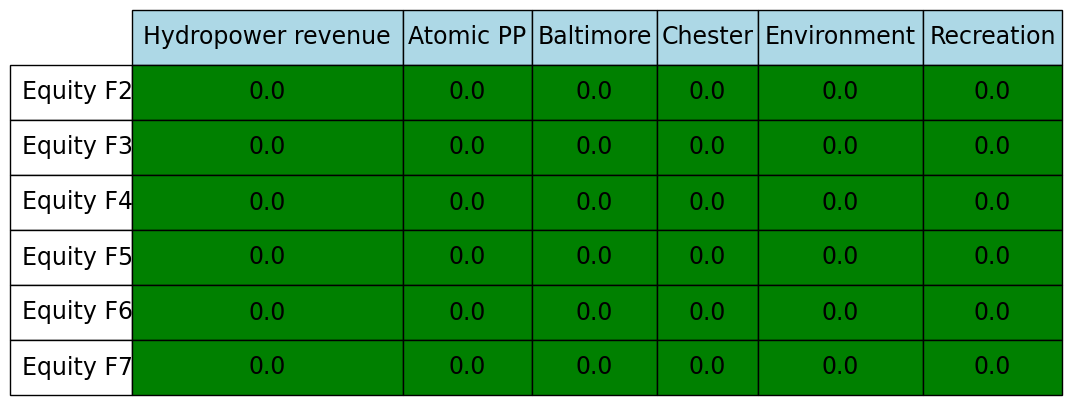

In [9]:

# Define the desired column names
column_names = ['Hydropower revenue', 'Atomic PP', 'Baltimore', 'Chester', 'Environment', 'Recreation',]
# Create a table to store p-values
p_values_table = pd.DataFrame(columns=column_names)

formulations_number = [f'F{i}' for i in range(2,8)]

j = 0

for df in list_df:
    print(f"\nFormulation: {df.name}")
    
    # Create a row index based on the dataframe name
    row_index = f'Equity {formulations_number[j]}'
    j+=1

    # Create a row to store p-values for the equity column
    p_values_row = []
    
    
    # Iterate over each column
    for col in column_names:
        y = df[col]
        x = df['Equity']
        h, p_value = stats.kruskal(x, y)
        
        # Append p-value to the row
        p_values_row.append(p_value)
    
    # Add the p-values row to the table
    p_values_table.loc[row_index] = p_values_row

# Create a colormap for coloring the cells
cmap = plt.cm.get_cmap('RdYlGn')

# Create a figure and axis for the table
fig, ax = plt.subplots()
ax.axis('off')

# Plot the table
table = ax.table(cellText=p_values_table.values.round(4),
                 colLabels=p_values_table.columns,
                 rowLabels=p_values_table.index,
                 cellColours=np.where(p_values_table < 0.05, 'green', 'red'),
                 colColours=['lightblue'] * len(p_values_table.columns),
                 cellLoc='center',  # Align cell text to the center
                 bbox=[0, 0, 1, 1])

# Adjust the font size and cell padding
table.set_fontsize(17)
table.scale(1, 1.5)
table.auto_set_column_width([0] + list(range(1, len(column_names) + 1)))  # Adjust column width

# Show the plot
plt.show()

## Mann-Whitney U test

The Mann-Whitney U test is a nonparametric test that does not assume any particular distribution for the data. Instead of comparing means, it compares the distributions of the two groups by ranking all of the observations and comparing the sum of the ranks in each group. The Mann-Whitney U test is more appropriate for data that is not normally distributed or when the variances of the two groups are unequal. It is also more robust to outliers than the t-test.

In [10]:

df_traditional = pd.DataFrame(reference_sets[ethical_formulations[0]].iloc[:,-7:-2])
df_traditional.name = ethical_formulations[0]
df_gini_mean = pd.DataFrame(reference_sets[ethical_formulations[1]].iloc[:,-7:-2])
df_gini_mean.name = ethical_formulations[1]
df_gini_std = pd.DataFrame(reference_sets[ethical_formulations[2]].iloc[:,-7:-2])
df_gini_std.name = ethical_formulations[2]
df_gini_ratio = pd.DataFrame(reference_sets[ethical_formulations[3]].iloc[:,-7:-2])
df_gini_ratio.name = ethical_formulations[3]
df_eucli_mean = pd.DataFrame(reference_sets[ethical_formulations[4]].iloc[:,-7:-2])
df_eucli_mean.name = ethical_formulations[4]
df_eucli_std = pd.DataFrame(reference_sets[ethical_formulations[5]].iloc[:,-7:-2])
df_eucli_std.name = ethical_formulations[5]
df_eucli_ratio = pd.DataFrame(reference_sets[ethical_formulations[6]].iloc[:,-7:-2])
df_eucli_ratio.name = ethical_formulations[6]

list_df = [df_traditional, df_gini_mean,df_gini_std,df_gini_ratio,df_eucli_mean, df_eucli_std,df_eucli_ratio]

### Mann-Whitney for all shared objectives across formulations

In [11]:
for i in range(len(list_df)):
    for j in range(i+1, len(list_df)):
        print(f"\nComparing dataframes {list_df[i].name} and {list_df[j].name}")
        
        # Get the column names that are in both dataframes
        shared_cols = set(list_df[i].columns) & set(list_df[j].columns)
        
        # Loop over all pairs of columns in the two dataframes
        for col in shared_cols:
            u, p = mannwhitneyu(list_df[i][col], list_df[j][col], alternative='two-sided')
            print(f"Column {col}: U-statistic={u:.2f}, p-value={p:.7f}")
            


Comparing dataframes TraditionalPrinciple and CombinedTraditionalGiniMean
Column Environment: U-statistic=33660.00, p-value=0.1317479
Column Atomic PP: U-statistic=40730.00, p-value=0.0196490
Column Hydropower revenue: U-statistic=35180.00, p-value=0.4955513
Column Baltimore: U-statistic=34714.00, p-value=0.3499634
Column Chester: U-statistic=33132.00, p-value=0.0728003

Comparing dataframes TraditionalPrinciple and CombinedTraditionalGiniStd
Column Environment: U-statistic=23084.00, p-value=0.0086892
Column Atomic PP: U-statistic=31966.00, p-value=0.0004383
Column Hydropower revenue: U-statistic=23477.00, p-value=0.0186556
Column Baltimore: U-statistic=27423.00, p-value=0.7076149
Column Chester: U-statistic=30190.00, p-value=0.0221348

Comparing dataframes TraditionalPrinciple and CombinedTraditionalGiniRatioStdMean
Column Environment: U-statistic=32007.00, p-value=0.0000826
Column Atomic PP: U-statistic=46738.00, p-value=0.0004489
Column Hydropower revenue: U-statistic=37702.00, p-v

In [12]:

# Create a dictionary to store the comparison results
results = {'Formulation 1': [], 'Formulation 2': [], 'Objective': [], 'p-value': []}

# Loop over the comparison results and store the relevant information in the dictionary
for i in range(len(list_df)):
    for j in range(i+1, len(list_df)):
        df1_name = list_df[i].name
        df2_name = list_df[j].name
        shared_cols = set(list_df[i].columns) & set(list_df[j].columns)
        for col in shared_cols:
            u, p = mannwhitneyu(list_df[i][col], list_df[j][col], alternative='two-sided')
            results['Formulation 1'].append(df1_name)
            results['Formulation 2'].append(df2_name)
            results['Objective'].append(col)
            results['p-value'].append(p)

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame(results)

# Create a function to apply custom styling
def highlight_pvalue(p):
    color = 'red' if p > 0.05 else 'green'
    return f'color: {color}'

# Apply the custom styling to the p-value column
highlighted_df = results_df.style.applymap(highlight_pvalue, subset=['p-value'])

# Render the styled DataFrame as HTML
styled_html = highlighted_df.render()

# Save the HTML to a file
with open("Mann_Whitney_across_formulations_same_objective.html", "w") as file:
    file.write(styled_html)
    
# Display the highlighted DataFrame
highlighted_df



/var/folders/fb/0thbs3j11t5f5j12jp7nctzw0000gn/T/ipykernel_45515/2214369797.py:29: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  styled_html = highlighted_df.render()


,Formulation 1,Formulation 2,Objective,p-value
0,TraditionalPrinciple,CombinedTraditionalGiniMean,Environment,0.131748
1,TraditionalPrinciple,CombinedTraditionalGiniMean,Atomic PP,0.019649
2,TraditionalPrinciple,CombinedTraditionalGiniMean,Hydropower revenue,0.495551
3,TraditionalPrinciple,CombinedTraditionalGiniMean,Baltimore,0.349963
4,TraditionalPrinciple,CombinedTraditionalGiniMean,Chester,0.072800
5,TraditionalPrinciple,CombinedTraditionalGiniStd,Environment,0.008689
6,TraditionalPrinciple,CombinedTraditionalGiniStd,Atomic PP,0.000438
7,TraditionalPrinciple,CombinedTraditionalGiniStd,Hydropower revenue,0.018656
8,TraditionalPrinciple,CombinedTraditionalGiniStd,Baltimore,0.707615
9,TraditionalPrinciple,CombinedTraditionalGiniStd,Chester,0.022135


There is statistical significance in the difference between the distribution of objectives across different formulations when the p-value exceeds 0.05. In that case, we say that the Null Hypothesis is False. The Null Hypothesis refers to the assumption that the distribution across objectives is different because of randomness, and not because of the formulation itself. The p-value < 0.05 (95% confidence that the Null Hypothesis is False). 

The distribution for the atomic power plant shows that the p-value exceeds 0.05 between several of the formulations. Between the traditional formulation and formulations with distributive justice, the p-value will always exceed 0.05 for the atomic power plant. Subsequently, the trade-off for the atomic power plant objective will not be unique to the formulation observed. 

The p-value between the Traditional Formulation and the Gini Mean will exceed 0.05 as well for the Hydropower revenue, Chester, Baltimore, and the Environment. Only for the Euclidean Mean the p-value does not exceed 0.05 for any objective. For the other formulations, the distribution of objectives is similar across formulations.  We can confirm that the trade-off that rises from optimizing the traditional formulation and optimizing the traditional formulation with a complementing justice formulation will be distincitive, because for other objectives the null hypothesis can be rejected (p-value < 0.05), meaning the distribution across the same objectives have statistical significance in the way they are distributed. The exception here is for the Gini Mean where the p-value of several distributions are above 0.05. The Gini Mean will lead to similar trade-offs across objective as the Traditional Formulation.

Interestingly, while the Gini formulations have a high p-value when comparing this objective across different aggregation methods over time, for the Euclidean formulation this is not the case. Hence, the Gini, regardless of the aggregation method over time seems to provide solutions with the same trade-off for the atomic power plant objective.

When the distribution is compared across inequality metrics, with the same aggregation method formulation, we notice that the standard deviation formulations (i.e. standard deviation, and ratio between standard deviation and mean) will yield a higher p-value, meaning their distribution is significantly similar for several of the objectives. A reason for this could be the fact that we made the assumption of duplicating the yearly mean value across every month. This made the distribution across months less significant, and the solutions identified more dependent on the same information as the yearly mean. In the end, we can conclude that the p-value exceeding 0.05 across inequality metrics, indicates that the aggregation method over time has a stronger influence on the distribution rising from the optimization.

We notice as well some outliers such as the p-value for four objectives (hydropower, baltimore, atomic, recreation) between the Gini Mean formulation and Euclidean Std exceeding 0.05. The same happens between the Gini Std formulation and the Euclidean Std (three p-values exceeding 0.05), and Euclidean Ratio (five p-values exceeding 0.05). The trade-off across solutions will thus be similar for these objectives. An explanation to this is that the epsilon values for the search of nondominated solutions is very large. This is because we wanted to find global optima, and not all solutions, which yields many local optima solutions. This leads to global optima solutions across formulations being very similar, while a smaller epsilon value will indicate, as expected, that there is no similarity in the distribution from objectives across formulations.


Nevertheless, most objectives satisfy a difference in distribution across formulation. These results are expected, having for some of the objectives similarities across formulations is expected since out of the seven objectives, one objective has been changed throughout formulations. When the optimization algorithm is working, it is still finding similar solutions that satisfy the other six objectives. It can be concluded that the Pareto front, relative to six other efficiency objectives, is not sensitive to the change from implementing solely one distributive justice objective .

**For other objectives, there is always a p-value < 0.05 between formulations over inequality metric, and over aggregation method**

### Mann-Whitney U test for all pairwise combinations of objectives

In [13]:
import itertools

# Loop over all pairs of dataframes
for i in range(len(list_df)):
    print(i)
    for j in range(i+1, len(list_df)):
        print(f"\nComparing dataframes {list_df[i].name} and {list_df[j].name}")
        
        # Get the column names that are in both dataframes
        shared_cols = set(list_df[i].columns) & set(list_df[j].columns)
        
        # Loop over all pairwise combinations of shared columns
        for col1, col2 in itertools.combinations(shared_cols, 2):
            u, p = mannwhitneyu(list_df[i][col1], list_df[j][col2], alternative='two-sided')
            print(f"Columns {col1} and {col2}: U-statistic={u:.2f}, p-value={p:.7f}")

0

Comparing dataframes TraditionalPrinciple and CombinedTraditionalGiniMean
Columns Environment and Atomic PP: U-statistic=69.00, p-value=0.0000000
Columns Environment and Hydropower revenue: U-statistic=0.00, p-value=0.0000000
Columns Environment and Baltimore: U-statistic=1956.00, p-value=0.0000000
Columns Environment and Chester: U-statistic=0.00, p-value=0.0000000
Columns Atomic PP and Hydropower revenue: U-statistic=0.00, p-value=0.0000000
Columns Atomic PP and Baltimore: U-statistic=59786.00, p-value=0.0000000
Columns Atomic PP and Chester: U-statistic=43746.00, p-value=0.0000714
Columns Hydropower revenue and Baltimore: U-statistic=72870.00, p-value=0.0000000
Columns Hydropower revenue and Chester: U-statistic=72870.00, p-value=0.0000000
Columns Baltimore and Chester: U-statistic=15398.00, p-value=0.0000000

Comparing dataframes TraditionalPrinciple and CombinedTraditionalGiniStd
Columns Environment and Atomic PP: U-statistic=377.00, p-value=0.0000000
Columns Environment and Hy

Columns Environment and Baltimore: U-statistic=41006.00, p-value=0.0000000
Columns Environment and Chester: U-statistic=16261.00, p-value=0.0000000
Columns Atomic PP and Hydropower revenue: U-statistic=0.00, p-value=0.0000000
Columns Atomic PP and Baltimore: U-statistic=299954.00, p-value=0.0000000
Columns Atomic PP and Chester: U-statistic=219495.00, p-value=0.0013081
Columns Hydropower revenue and Baltimore: U-statistic=490314.00, p-value=0.0000000
Columns Hydropower revenue and Chester: U-statistic=490314.00, p-value=0.0000000
Columns Baltimore and Chester: U-statistic=184451.00, p-value=0.0000000
5

Comparing dataframes CombinedTraditionalEuclideanStd and CombinedTraditionalEuclideanRatioStdMean
Columns Environment and Atomic PP: U-statistic=1552.00, p-value=0.0000000
Columns Environment and Hydropower revenue: U-statistic=0.00, p-value=0.0000000
Columns Environment and Baltimore: U-statistic=3909.00, p-value=0.0000000
Columns Environment and Chester: U-statistic=50.00, p-value=0.0

In [14]:
# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=["Formulation 1", "Formulation 2", "Objective 1", "Objective 2", "p-value"])

# Loop over all pairs of dataframes
for i in range(len(list_df)-1):
    for j in range(i+1, len(list_df)):
        print(f"\nComparing dataframes {list_df[i].name} and {list_df[j].name}")
        
        # Get the column names that are in both dataframes
        shared_cols = set(list_df[i].columns) & set(list_df[j].columns)
        
        # Loop over all pairwise combinations of shared columns
        for col1, col2 in itertools.combinations(shared_cols, 2):
            u, p = mannwhitneyu(list_df[i][col1], list_df[j][col2], alternative='two-sided')            
            # Add the results to the DataFrame
            results_df = results_df.append({
                "Formulation 1": list_df[i].name,
                "Formulation 2": list_df[j].name,
                "Objective 1": col1,
                "Objective 2": col2,
                "p-value": p
            }, ignore_index=True)
            
results_df = results_df.style.applymap(highlight_pvalue, subset=['p-value'])

# Render the styled DataFrame as HTML
styled_html = highlighted_df.render()

# Save the HTML to a file
with open("Mann_Whitney_across_formulations_across_objectives.html", "w") as file:
    file.write(styled_html)
    
results_df



Comparing dataframes TraditionalPrinciple and CombinedTraditionalGiniMean

Comparing dataframes TraditionalPrinciple and CombinedTraditionalGiniStd

Comparing dataframes TraditionalPrinciple and CombinedTraditionalGiniRatioStdMean

Comparing dataframes TraditionalPrinciple and CombinedTraditionalEuclideanMean

Comparing dataframes TraditionalPrinciple and CombinedTraditionalEuclideanStd

Comparing dataframes TraditionalPrinciple and CombinedTraditionalEuclideanRatioStdMean

Comparing dataframes CombinedTraditionalGiniMean and CombinedTraditionalGiniStd

Comparing dataframes CombinedTraditionalGiniMean and CombinedTraditionalGiniRatioStdMean

Comparing dataframes CombinedTraditionalGiniMean and CombinedTraditionalEuclideanMean

Comparing dataframes CombinedTraditionalGiniMean and CombinedTraditionalEuclideanStd

Comparing dataframes CombinedTraditionalGiniMean and CombinedTraditionalEuclideanRatioStdMean

Comparing dataframes CombinedTraditionalGiniStd and CombinedTraditionalGiniRatioS

/var/folders/fb/0thbs3j11t5f5j12jp7nctzw0000gn/T/ipykernel_45515/310628009.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/var/folders/fb/0thbs3j11t5f5j12jp7nctzw0000gn/T/ipykernel_45515/310628009.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/var/folders/fb/0thbs3j11t5f5j12jp7nctzw0000gn/T/ipykernel_45515/310628009.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/var/folders/fb/0thbs3j11t5f5j12jp7nctzw0000gn/T/ipykernel_45515/310628009.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({



Comparing dataframes CombinedTraditionalGiniStd and CombinedTraditionalEuclideanStd

Comparing dataframes CombinedTraditionalGiniStd and CombinedTraditionalEuclideanRatioStdMean

Comparing dataframes CombinedTraditionalGiniRatioStdMean and CombinedTraditionalEuclideanMean

Comparing dataframes CombinedTraditionalGiniRatioStdMean and CombinedTraditionalEuclideanStd

Comparing dataframes CombinedTraditionalGiniRatioStdMean and CombinedTraditionalEuclideanRatioStdMean

Comparing dataframes CombinedTraditionalEuclideanMean and CombinedTraditionalEuclideanStd

Comparing dataframes CombinedTraditionalEuclideanMean and CombinedTraditionalEuclideanRatioStdMean

Comparing dataframes CombinedTraditionalEuclideanStd and CombinedTraditionalEuclideanRatioStdMean


/var/folders/fb/0thbs3j11t5f5j12jp7nctzw0000gn/T/ipykernel_45515/310628009.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/var/folders/fb/0thbs3j11t5f5j12jp7nctzw0000gn/T/ipykernel_45515/310628009.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/var/folders/fb/0thbs3j11t5f5j12jp7nctzw0000gn/T/ipykernel_45515/310628009.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/var/folders/fb/0thbs3j11t5f5j12jp7nctzw0000gn/T/ipykernel_45515/310628009.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


,Formulation 1,Formulation 2,Objective 1,Objective 2,p-value
0,TraditionalPrinciple,CombinedTraditionalGiniMean,Environment,Atomic PP,0.000000
1,TraditionalPrinciple,CombinedTraditionalGiniMean,Environment,Hydropower revenue,0.000000
2,TraditionalPrinciple,CombinedTraditionalGiniMean,Environment,Baltimore,0.000000
3,TraditionalPrinciple,CombinedTraditionalGiniMean,Environment,Chester,0.000000
4,TraditionalPrinciple,CombinedTraditionalGiniMean,Atomic PP,Hydropower revenue,0.000000
5,TraditionalPrinciple,CombinedTraditionalGiniMean,Atomic PP,Baltimore,0.000000
6,TraditionalPrinciple,CombinedTraditionalGiniMean,Atomic PP,Chester,0.000071
7,TraditionalPrinciple,CombinedTraditionalGiniMean,Hydropower revenue,Baltimore,0.000000
8,TraditionalPrinciple,CombinedTraditionalGiniMean,Hydropower revenue,Chester,0.000000
9,TraditionalPrinciple,CombinedTraditionalGiniMean,Baltimore,Chester,0.000000


Luckily, the distribution between objectives from different formulations are different such that the null hypothesis can be rejected for most objectives. Only between the Mean (aggregation over time) formulations  we observe that the distributions of the atomic plant objective and the chester objective are not random, hence the distribution of objective values for both objectives will be similar when it is compared across Mean formulations. This means that such formulations will share the same shift in Pareto frontFor other objectives, there is a statistical difference between the distribution of objectives. This means, that when we compare the distribution of objectives (as will be done in the boxplot analysis) the Pareto front is shifting differently across the formulations, regardless of the objective formulation, inequality metrics, or aggregation method over time.

Nonetheless, since the p-value is low for other objectives, we cannot determine how the Pareto front is shifting due to different formulations. That is why we decide to visually plot the solutions to gain a better understanding for the other objectives. We now understand the general role of inequality metrics, and the role of aggregation over time for the balitmore reliability, chester reliability, and (for some of the formulations) for the atomic plant reliability.